# Imports

In [1]:
import sys, gym
sys.path.append('../..')
from markov.Policies import EpsilonGreedyPolicy, RandomPolicy, QTablePolicy
from markov.Training import Agent, Academy
from markov.Metrics import CumulativeRewardFactory, EpisodeReward, ModelReadiness
from markov.Training import AgentConfig, AgentMetrics, get_curriculum_training_callbacks
import warnings
warnings.filterwarnings('ignore')

2024-07-07 16:51:30.876537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 16:51:31.563406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Training

#### Actual Training

In [2]:
agent_configs = {
    # "RandomWitness": AgentConfig(
    #     policy   = RandomPolicy()
    # ),
    "Q-best": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 1.0,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 0.808, gamma = 0.852),
        ),
        model_readiness      = True,
    ),
    "Q-a1": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.4,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 1, gamma = 0.9),
        ),
        model_readiness      = True,
        # get_curriculum_training_callbacks=get_curriculum_training_callbacks
    ),
    "Q-a0.8": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.4,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 0.8, gamma = 0.9)
        ),
        model_readiness      = True,
        # get_curriculum_training_callbacks=get_curriculum_training_callbacks
    ),
    "Q-a0.6": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.4,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 0.6, gamma = 0.9)
        ),
        model_readiness      = True,
        # get_curriculum_training_callbacks=get_curriculum_training_callbacks
    ),
    "Q-a0.4": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.4,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 0.4, gamma = 0.9)
        ),
        model_readiness      = True,
        # get_curriculum_training_callbacks=get_curriculum_training_callbacks
    ),
    "Q-a0.2": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 0.4,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 0.2, gamma = 0.9)
        ),
        model_readiness      = True,
        # get_curriculum_training_callbacks=get_curriculum_training_callbacks
    ),
    "Q-best-cl": AgentConfig(
        policy   = EpsilonGreedyPolicy(
            epsilon             = 1.0,
            exploration_policy  = RandomPolicy(),
            exploitation_policy = QTablePolicy(alpha = 0.808, gamma = 0.852),
        ),
        model_readiness      = True,
        get_curriculum_training_callbacks=get_curriculum_training_callbacks
    ),
}

academy = Academy(
    env     = gym.make("Taxi-v3"),
    agents  = agent_configs,
    metrics = AgentMetrics(
        step_metrics    = { "CumulativeReward"  : CumulativeRewardFactory() },
        episode_metrics = { "EpisodeReward"     : EpisodeReward },   
        model_readiness_metrics  = { "ModelReadiness" :ModelReadiness }
    )
)
training_metrics = academy.Train(1000)
academy.closeEnvs()


#### Compare agent training stats

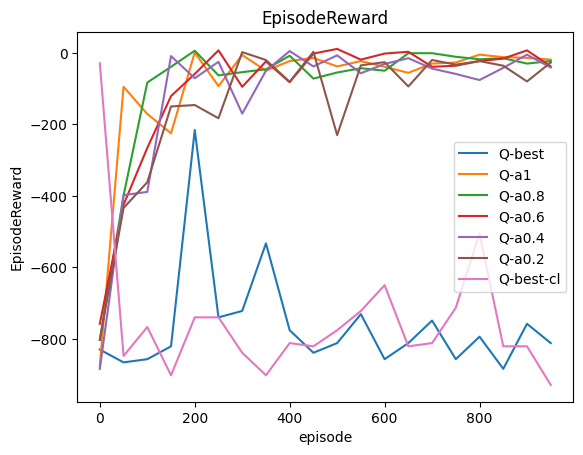

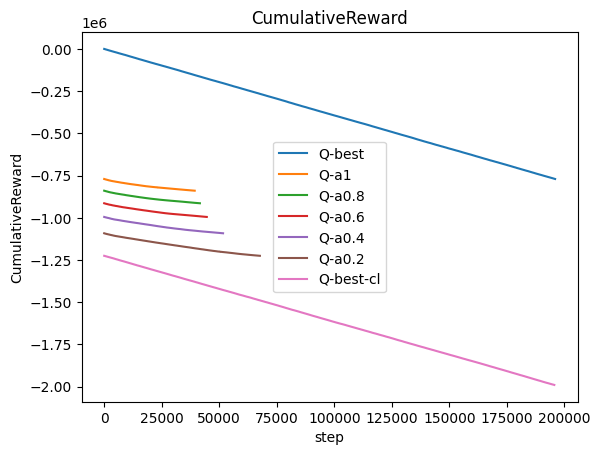

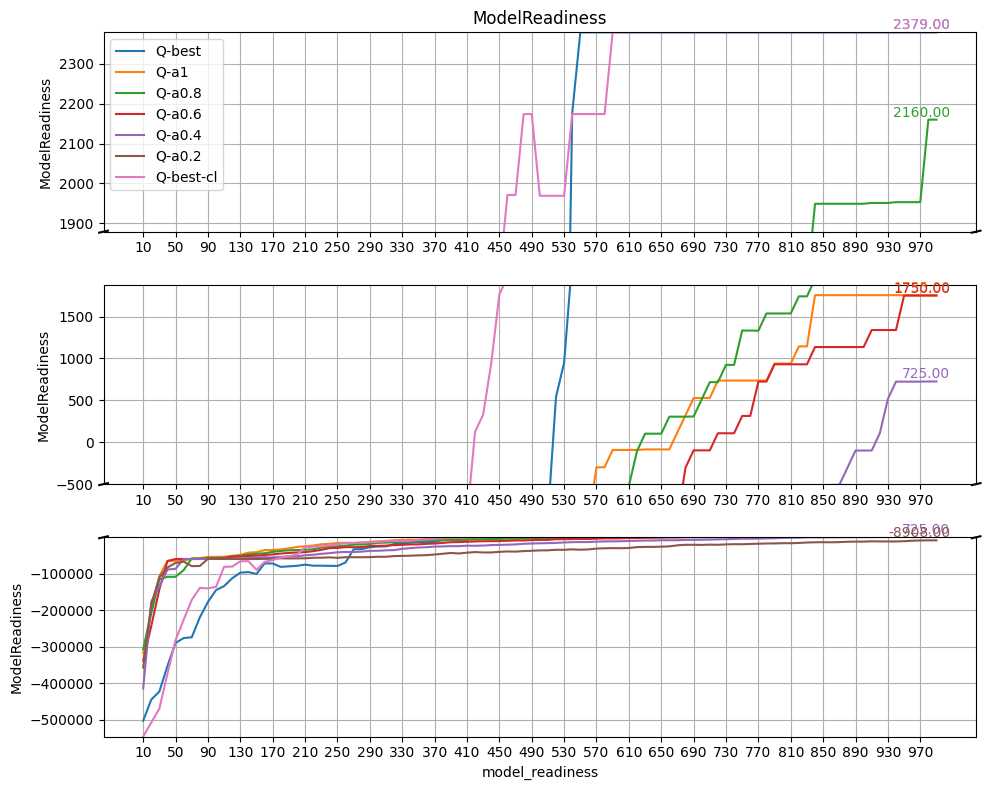

In [9]:
import matplotlib.pyplot as plt
from markov.Comparison import PlotMetricsComparison, PlotMetricsComparisonBrokenAxes

PlotMetricsComparison(
    agent_metrics   = training_metrics,
    type            = "episode",
    step            = 50
)

PlotMetricsComparison(
    agent_metrics   = training_metrics,
    type            = "step",
    step            = 1
)
PlotMetricsComparisonBrokenAxes(
    agent_metrics   = training_metrics,
    type            = "model_readiness",
    step            = 4,
    top_focus=500,
    mid_focus=2379
    )


Notes:
- The CumulativeReward plot of each agent starts where the previous stopped because of an implementation mistake (every agent uses the same closure returned by CumulativeRewardFactory(), therefore using the same accumulator variable ) 
- every agent is trained the same number of episodes, but those learning quicker use less steps since they win each episode faster
- The greater the alpha the shorter the training is.

# Tests

#### Test a specific agent (Renderer)

In [4]:
from markov.Metrics import EpisodeTerminated
from markov.Training import AgentMetrics

AGENT_TO_TEST   = "Q-best"
EPISODES        = 10

In [5]:
inference_env = gym.make("Taxi-v3", render_mode="human")

inference_metrics = academy.Infere(
    env         = inference_env,
    episodes    = EPISODES,
    agent_name  = AGENT_TO_TEST,
)

state 164 + action 3 => state 64 and reward -1 (On-Going)
state 64 + action 4 => state 84 and reward -1 (On-Going)
state 84 + action 0 => state 96 and reward -1 (On-Going)
state 96 + action 5 => state 76 and reward -1 (On-Going)
state 76 + action 5 => state 56 and reward -1 (On-Going)
state 56 + action 2 => state 156 and reward -1 (On-Going)
state 156 + action 2 => state 256 and reward -1 (On-Going)
state 256 + action 5 => state 236 and reward -1 (On-Going)
state 236 + action 5 => state 216 and reward -1 (On-Going)
state 216 + action 3 => state 116 and reward -1 (On-Going)
state 116 + action 3 => state 16 and reward -1 (On-Going)
state 16 + action 1 => state 0 and reward 20 (Done)
state 241 + action 5 => state 221 and reward -1 (On-Going)
state 221 + action 5 => state 201 and reward -1 (On-Going)
state 201 + action 3 => state 101 and reward -1 (On-Going)
state 101 + action 3 => state 1 and reward -1 (On-Going)
state 1 + action 0 => state 17 and reward -1 (On-Going)
state 17 + action 2 

In [6]:
inference_env.close()

#### Compare agents

In [7]:
from markov.Metrics import EpisodeTerminated
from markov.Training import AgentMetrics

# inference_env = gym.make("Taxi-v3", render_mode="human")
inference_env = gym.make("Taxi-v3")

inference_metrics = academy.Infere(
    env         = inference_env,
    episodes    = 1000,
    metrics     = AgentMetrics(
        episode_metrics = { 
            "EpisodeReward" : EpisodeReward,
            "EpisodeWon"    : EpisodeTerminated,
        }
    )
)
inference_env.close()

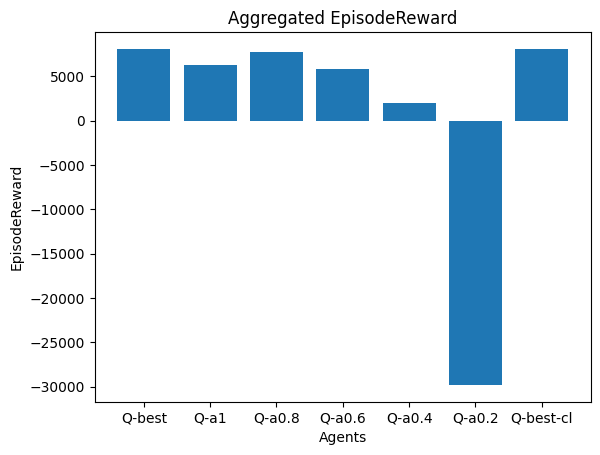

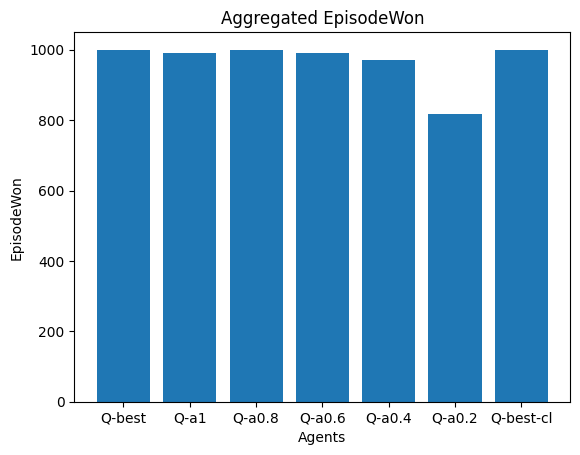

In [8]:
import matplotlib.pyplot as plt
from markov.Comparison import BarAggregatedMetricsComparison, PlotMetricsComparison

BarAggregatedMetricsComparison(
    agent_metrics   = inference_metrics,
    type            = "episode",
    agg             = sum
)


# Conclusion

- The **higher the learning rate is the faster the agent improves** (see `Episode Reward` and `Cumulative Reward` graphs)

- It seems no matter the learning rate, **all agents converge to a 100% success rate** (see `Aggregated EpisodeWon` : when the number of training episode increseases, so does the score of each agent)